In [77]:
import os
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset as TorchDataset
import torchaudio, torch
import torch.nn as nn
import torch.nn.functional as F # TODO: change all instances of nn and F to use these instead of torch. ...
import pandas as pd


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

cuda
0
NVIDIA GeForce RTX 4060 Laptop GPU


### Set program hyperparameters

In [79]:
USE_EVEN_DATASETS = False # whether to use all the data, or evenly sized classes

In [80]:
if USE_EVEN_DATASETS:
    EPOCHS = 525
    SAMPLES_PER_CLASS = 25
else:
    EPOCHS = 150
    SAMPLES_PER_CLASS = None

### Preprocess the original dataset

In [81]:
# modify the original dataset to be better structured and have english labels

src = 'dataset'

substitutions = {
    'Aslan' : 'Lion',
    'Esek' : 'Donkey',
    'Inek' : 'Cow',
    'Kedi' : 'Cat',
    'Kopek' : 'Dog',
    'Koyun' : 'Sheep',
    'Kurbaga' : 'Frog',
    'Kus' : 'Bird',
    'Maymun' : 'Monkey',
    'Tavuk' : 'Chicken'
}

og_src_files = os.listdir(src)

for fname in og_src_files:

    # build the path to the folder
    folder_path = os.path.join(src, fname)

    if not os.path.isdir(folder_path): continue # skip if not a folder

    subst_key = None
    for key,val in substitutions.items(): # find the turkish word to switch to english
        if fname.startswith(key):
            subst_key = key
            break
    
    if subst_key is None: continue # could not rename file
    
    new_folder_path = os.path.join(src, substitutions[subst_key])
    
    if not os.path.exists(new_folder_path): os.mkdir(new_folder_path) # make the new folder if it doesn't already exist

    og_files = os.listdir(folder_path)

    for file_name in og_files:
        file_path = os.path.join(folder_path, file_name)
        
        if not os.path.isfile(file_path): continue # this is not a file

        new_file_name = file_name
        if file_name.startswith(subst_key.lower()) or file_name.startswith(subst_key):
            new_file_name = substitutions[subst_key] + file_name[len(subst_key):]
        elif file_name.startswith(substitutions[subst_key].lower()) or file_name.startswith(substitutions[subst_key]):
            new_file_name = substitutions[subst_key] + file_name[len(substitutions[subst_key]):]
        
        new_file_path = os.path.join(new_folder_path, new_file_name)
        print(new_file_path)
        os.rename(file_path, new_file_path)

    os.rmdir(folder_path)
    


### Test the dataset

(190400,) 16000


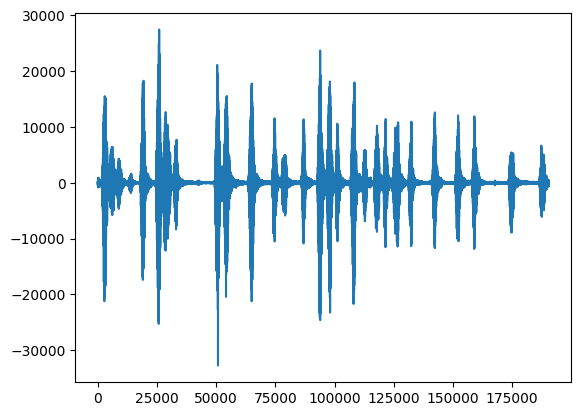

In [82]:
samplerate, data = wavfile.read('dataset/Dog/Dog_2.wav')
print(data.shape, samplerate)
plt.plot(data)
Audio(data, rate=samplerate)

### Data Access Helper Functions

In [83]:
labels = sorted(list(substitutions.values()))
print(labels)

def load_all_file_names_and_labels(root, samples_per_class=None):
    data_points = []
    for folder in os.listdir(root):
        folder_path = os.path.join(root, folder)
        if not os.path.isdir(folder_path): continue

        label = folder
        
        samples_for_this_class = 0
        for datapoint in os.listdir(folder_path):
            data_path = os.path.join(folder_path, datapoint)
            if not os.path.isfile(data_path): continue
            samples_for_this_class += 1
            data_points.append((data_path, label))
            if samples_per_class is not None and samples_per_class == samples_for_this_class: break
    return np.array(data_points)

def one_hot_lookup(labels):
    lookup = {}
    for i, label in enumerate(labels):
        lookup[label] = i
    return lookup

['Bird', 'Cat', 'Chicken', 'Cow', 'Dog', 'Donkey', 'Frog', 'Lion', 'Monkey', 'Sheep']


### Audio Processing Helper Functions

In [84]:
def audio_subclip(audio, time, samplerate):
    audio_len = audio.shape[-1]

    max_start = audio_len - (time * samplerate) + 1
    start_idx = torch.randint(0, max_start, size=(1,))
    clip = audio[:, start_idx: start_idx + (time * samplerate)]

    return clip

def pad_audio(audio, time, samplerate):
    audio_len = audio.shape[-1]

    if audio_len >= time * samplerate: return audio

    zeros_needed = time*samplerate - audio_len
    padded = torch.nn.functional.pad(audio, (0, zeros_needed), value=0)

    return padded

def single_channel(audio):
    return audio[[0],:]

### Dataset Class

In [85]:
class AnimalAudioDataset(TorchDataset):
    def __init__(self, dataset_path, labels, type = 'wave'):
        assert type in ['wave', 'full', 'freq']

        self.data_points = load_all_file_names_and_labels(dataset_path, SAMPLES_PER_CLASS)
        self.labels = labels
        self.lookup = one_hot_lookup(labels)
        self.universal_sample_rate = 4000 # 8000 is the min of our original data
        self.clip_time = 1 # 1 second clips
        self.spikes_path = 'spikes'
        self.type = type
        self.full_data = [self.get_item_helper(x).to(device) for x in range(len(self.data_points))]
        self.full_labels = torch.tensor([self.lookup[x[1]] for x in self.data_points]).to(device)
        self.torch_sr = torch.tensor(self.universal_sample_rate).to(device)

    def get_item_helper(self, index: int):
        path, _ = self.data_points[index]
        waveform, sample_rate = torchaudio.load(path)
        one_channel = single_channel(waveform) # some wav files are dual channel audio
        resampled_waveform = torchaudio.functional.resample(one_channel, orig_freq=sample_rate, new_freq=self.universal_sample_rate)
        
        full_data = resampled_waveform

        if self.type != 'wave':
            feature_count = 10
            start = 0
            if self.type == 'full':
                feature_count = 11
                start = 1
                
            full_data = torch.zeros((feature_count, full_data.shape[-1]))
            if self.type == 'full':
                full_data[0] = resampled_waveform

            spikes = torch.tensor(np.load(os.path.join(self.spikes_path, path) + '.npy'))
            data_len = min(spikes.shape[-1], full_data.shape[-1])
            full_data[start:, :data_len] = spikes[:, :data_len]

        return full_data


    def __getitem__(self, index: int): # -> Tuple[Tensor, int, str]:
        data = self.full_data[index]
        padded = pad_audio(data, self.clip_time, self.universal_sample_rate)
        clipped = audio_subclip(padded, self.clip_time, self.universal_sample_rate)

        return clipped, self.universal_sample_rate, self.full_labels[index]

    def __len__(self):
        return len(self.data_points)

In [86]:
wave_dataset = AnimalAudioDataset('dataset', labels, type='wave')
full_dataset = AnimalAudioDataset('dataset', labels, type='full')
freq_dataset = AnimalAudioDataset('dataset', labels, type='freq')

### Dataloader Generation

In [87]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

def get_train_test_loaders(dataset, test_size = 0.2):
    # we use this method to ensure the test/train have the same proportions of each class

    targets = [dataset.lookup[x] for x in dataset.data_points[:,1]]
    train_indices, test_indices, _, _ = train_test_split(
        range(len(dataset)),
        targets,
        stratify=targets,
        test_size=test_size
    )

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=256,
        shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False)
    
    return train_loader, test_loader

In [88]:
assert 'soundfile' in torchaudio.list_audio_backends()

### M5 Model

Code based on https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

Small reduction in scale to the M5 model

In [89]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        # self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        # self.bn4 = nn.BatchNorm1d(2 * n_channel)
        # self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        # x = self.conv4(x)
        # x = F.relu(self.bn4(x))
        # x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

### Evaluation Functions

For both these and the training, we assume the data and model will already be on the same device

In [90]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def correct_per_class(pred, target):
    correct = np.zeros((10))
    total = np.zeros((10))
    for i in range(target.shape[0]):
        total[target[i]] += 1
        if pred[i][0] == target[i]:
            correct[target[i]] += 1
    return correct, total


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def eval(model, data_loader, rnn=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, sample_rate, labels = data 
            outputs = model(inputs)
            if rnn:
                outputs = outputs[0]
            # print(torch.argmax(outputs), torch.argmax(labels))
            pred = get_likely_index(outputs)
            correct += number_of_correct(pred, labels)
    return correct/len(data_loader.dataset)

def eval_per_class(model, data_loader, rnn=False):
    model.eval()
    correct = np.zeros((10))
    total = np.zeros((10))
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, sample_rate, labels = data
            outputs = model(inputs)
            if rnn:
                outputs = outputs[0]
            # print(torch.argmax(outputs), torch.argmax(labels))
            pred = get_likely_index(outputs)
            new_correct, new_total = correct_per_class(pred, labels)
            correct += new_correct
            total += new_total
    return correct/total

### Training Functions

In [91]:
def train(model, loss_fn, optimizer, training_loader, epochs, rnn=False, get_accs=False, test_loader=None):
    if get_accs: assert (test_loader is not None)
    losses = []
    train_accs = []
    test_accs = []
    for epoch in range(epochs):
        model.train()
        print(f"Start of epoch {epoch}")
        running_loss = 0.

        for i, data in enumerate(training_loader):
            inputs, sample_rate, labels = data
            outputs = model(inputs)
            if rnn:
                outputs = outputs[0]

            loss = loss_fn(outputs.squeeze(), labels)
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        losses.append(running_loss/len(training_loader))
        print(losses[-1])

        if get_accs:
            train_accs.append(eval(model, training_loader, rnn=rnn))
            test_accs.append(eval(model, test_loader, rnn=rnn))
    
    if get_accs: return losses, train_accs, test_accs
    return losses

### Plotting Functions

In [92]:
def plot_loss_over_time(losses, title_addition=''):
    plt.figure()
    plt.plot(losses, color='blue')
    plt.title("Training Loss Over Time" + title_addition)
    plt.xlabel("Epoch #")
    plt.ylabel("Loss (NLL)")
    plt.show()

def plot_train_test_accs(train_accs, test_accs, title_addition=''):
    plt.figure()
    plt.plot(train_accs, label="Training", color='blue')
    plt.plot(test_accs, label="Testing", color='red')
    plt.title("Training and Testing Accuracy Over Time" + title_addition)
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

def plot_class_accuracies(accs, classes, title_addition=''):
    accs = 100*np.array(accs).round(2)
    plt.figure()
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Per Class" + title_addition)
    acc_bar = plt.bar(classes, accs, color='green', label='Correct %')
    plt.bar_label(acc_bar, label_type='center')
    inc_bar = plt.bar(classes, 100 - accs, bottom = accs, color='red', label='Incorrect %')
    plt.bar_label(inc_bar, label_type='center')

    plt.legend()
    plt.show()

def plot_features(data_loader, type, title_addition=''):
    assert type in ['wave', 'full', 'freq']
    
    x = None
    for inputs, _, _ in data_loader:
        x = inputs[0]
        break

    start = 0
    if type != 'freq':
        start += 1
        plt.figure()
        plt.title("Waveform" + title_addition)
        plt.plot(x[0])
        plt.show()
    
    if type != 'wave':
        for i in range(x.shape[-2] - start):
            plt.figure()
            plt.title("Firing rates, cf=" + str(1000*(i+1)) + title_addition)
            plt.plot(x[start + i])
            plt.show()

def plot_waveform(file, i, title_add=''):
    spikes = torch.tensor(np.load(os.path.join('spikes', file) + '.npy'))
    plt.figure()
    plt.title(title_add + "Firing rates, cf=" + str(1000*(i+1)))
    plt.ylabel("Firing Rate")
    plt.xlabel("Time Sample # at 4 KHz (x=4000 is at 1 second)")
    plt.plot(spikes[i])
    plt.show()

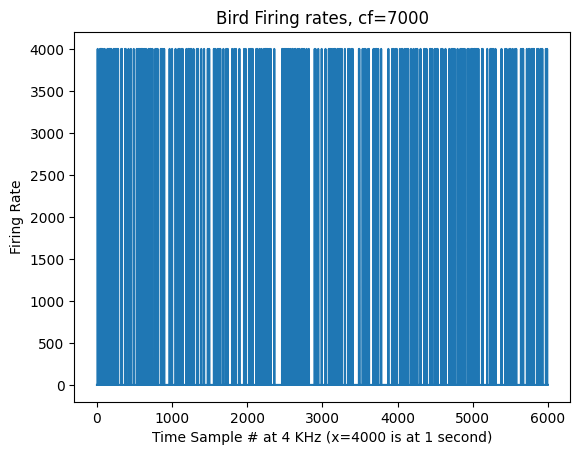

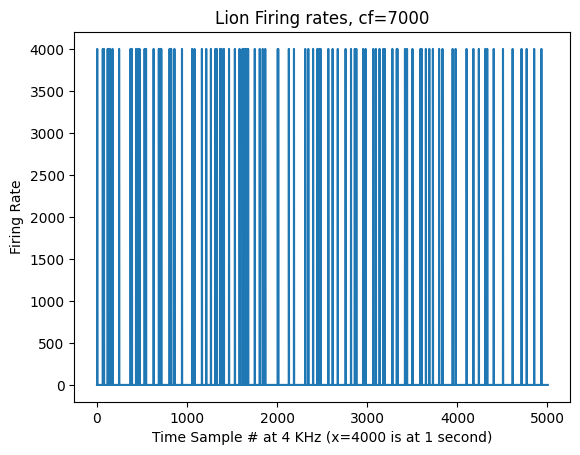

In [93]:
plot_waveform(os.path.join('dataset', 'Bird', 'Bird_1.wav'), 6, 'Bird ')
plot_waveform(os.path.join('dataset', 'Lion', 'Lion_2.wav'), 6, 'Lion ')

### Driver Code

Start of epoch 0
2.359905401865641
Start of epoch 1
2.128800312678019
Start of epoch 2
1.9707496166229248
Start of epoch 3
1.8690252701441448
Start of epoch 4
1.776797930399577
Start of epoch 5
1.7185864448547363
Start of epoch 6
1.6556787888209026
Start of epoch 7
1.592541257540385
Start of epoch 8
1.541800061861674
Start of epoch 9
1.5188388029734294
Start of epoch 10
1.4589598973592122
Start of epoch 11
1.4409496784210205
Start of epoch 12
1.405118187268575
Start of epoch 13
1.3901522954305012
Start of epoch 14
1.3284210364023845
Start of epoch 15
1.310738205909729
Start of epoch 16
1.2735170125961304
Start of epoch 17
1.2740017175674438
Start of epoch 18
1.2538715203603108
Start of epoch 19
1.222697099049886
Start of epoch 20
1.1959630648295085
Start of epoch 21
1.1871709028879802
Start of epoch 22
1.1649525165557861
Start of epoch 23
1.1192524035771687
Start of epoch 24
1.1267528931299846
Start of epoch 25
1.1194024085998535
Start of epoch 26
1.0939274628957112
Start of epoch 27
1

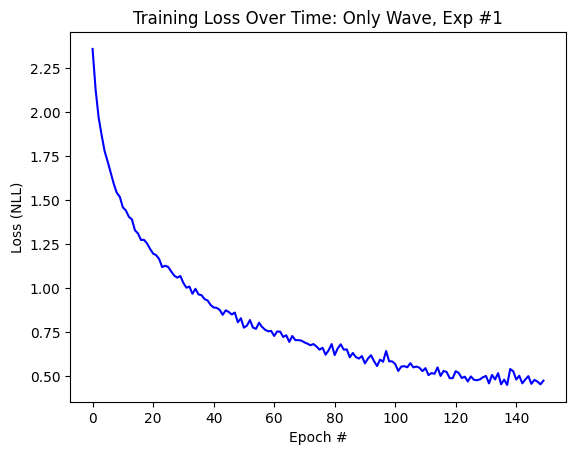

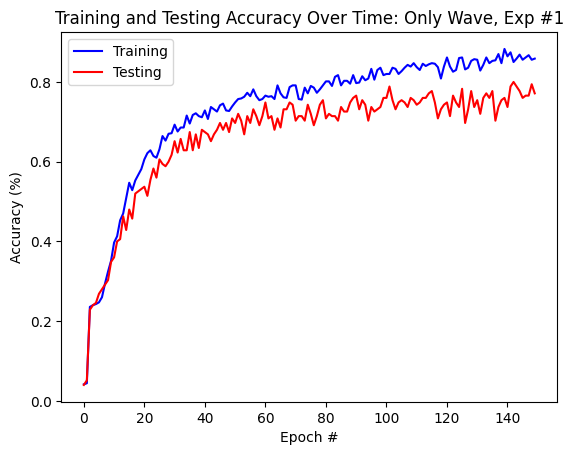

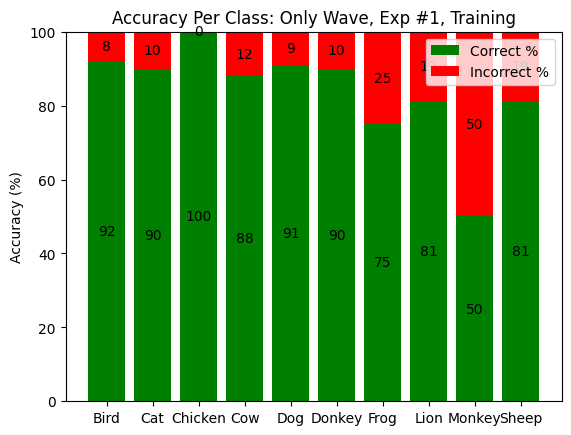

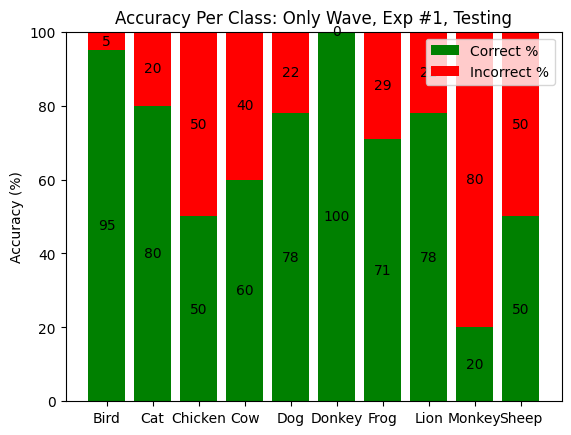

Start of epoch 0
2.3176839351654053
Start of epoch 1
2.054260532061259
Start of epoch 2
1.880692720413208
Start of epoch 3
1.7420978148778279
Start of epoch 4
1.6462971369425456
Start of epoch 5
1.5417025883992512
Start of epoch 6
1.5048510630925496
Start of epoch 7
1.4425353209177654
Start of epoch 8
1.4068479140599568
Start of epoch 9
1.3916213909784954
Start of epoch 10
1.3532187541325886
Start of epoch 11
1.3236496051152546
Start of epoch 12
1.2942181030909221
Start of epoch 13
1.2770351966222127
Start of epoch 14
1.2544771035512288
Start of epoch 15
1.247459848721822
Start of epoch 16
1.2296709219614665
Start of epoch 17
1.2205352783203125
Start of epoch 18
1.189340353012085
Start of epoch 19
1.190902312596639
Start of epoch 20
1.1736911535263062
Start of epoch 21
1.143805464108785
Start of epoch 22
1.1583904425303142
Start of epoch 23
1.1563982168833415
Start of epoch 24
1.1298393805821736
Start of epoch 25
1.1135276556015015
Start of epoch 26
1.1158973773320515
Start of epoch 27

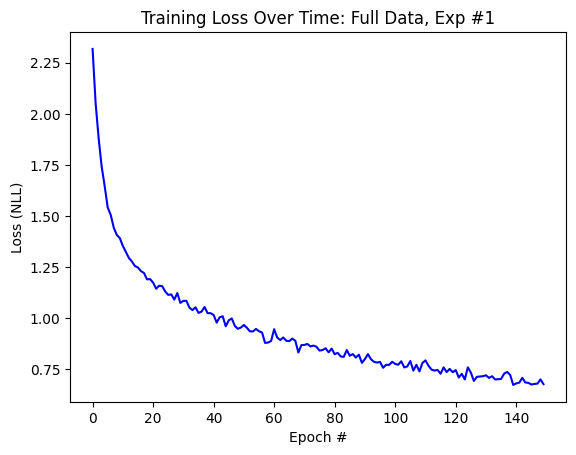

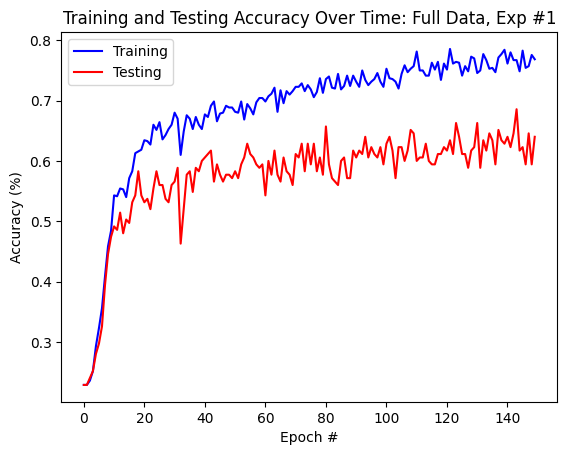

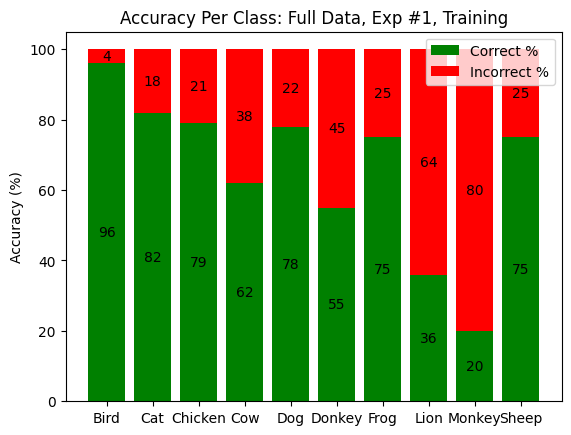

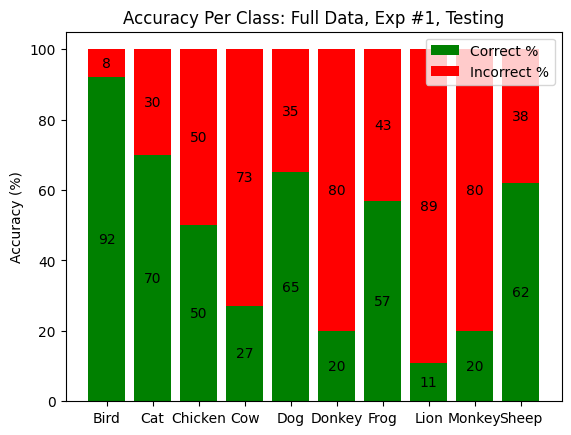

Start of epoch 0
2.22957173983256
Start of epoch 1
1.9589226643244426
Start of epoch 2
1.8106029033660889
Start of epoch 3
1.707613746325175
Start of epoch 4
1.6307893594106038
Start of epoch 5
1.5663777987162273
Start of epoch 6
1.523962418238322
Start of epoch 7
1.4977691173553467
Start of epoch 8
1.4521636168162029
Start of epoch 9
1.4493459860483806
Start of epoch 10
1.4204414288202922
Start of epoch 11
1.3980606396993
Start of epoch 12
1.370815912882487
Start of epoch 13
1.352938135464986
Start of epoch 14
1.3243258396784465
Start of epoch 15
1.3100093205769856
Start of epoch 16
1.2872542540232341
Start of epoch 17
1.2664244174957275
Start of epoch 18
1.257399559020996
Start of epoch 19
1.230878512064616
Start of epoch 20
1.2268157800038655
Start of epoch 21
1.2054062287012737
Start of epoch 22
1.2178049484888713
Start of epoch 23
1.1820626258850098
Start of epoch 24
1.1614917516708374
Start of epoch 25
1.1798397302627563
Start of epoch 26
1.1577082872390747
Start of epoch 27
1.16

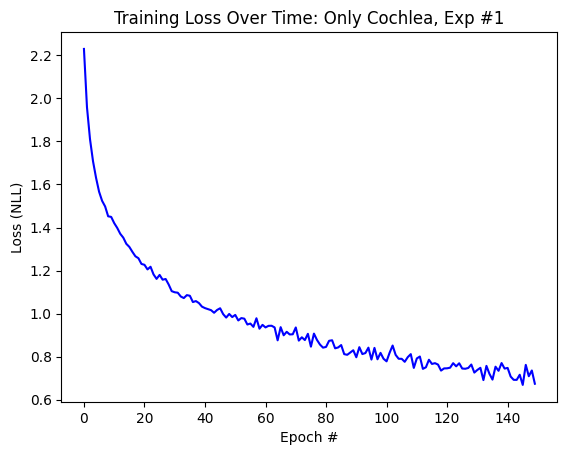

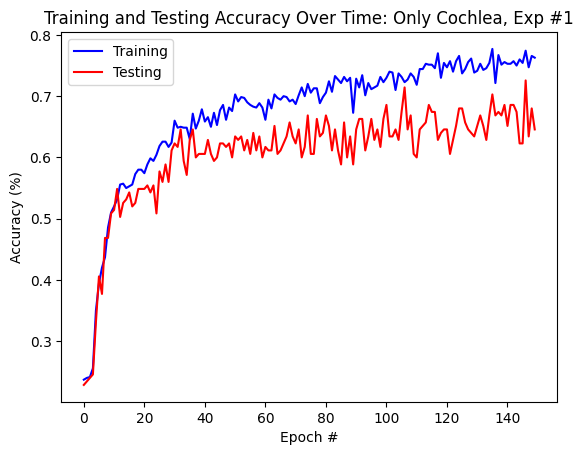

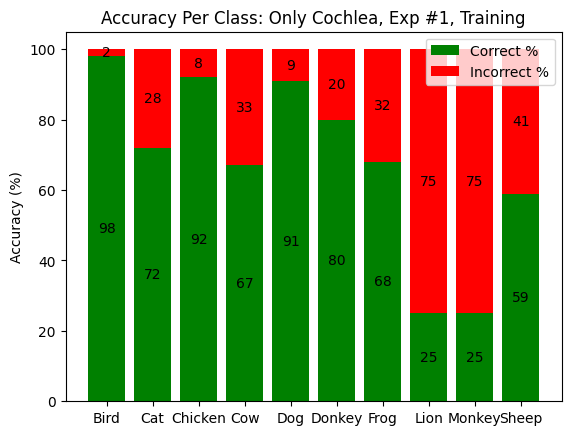

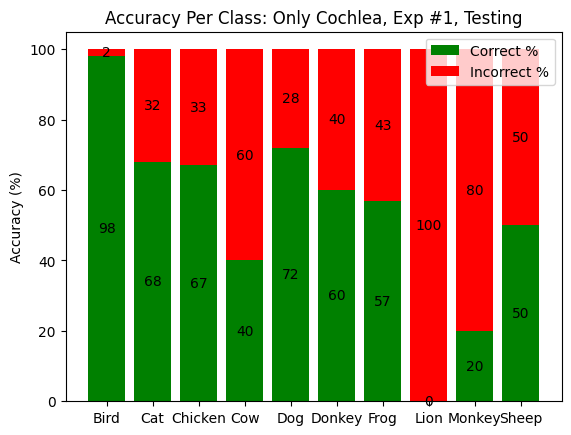

Start of epoch 0
2.473867734273275
Start of epoch 1
2.2047910690307617
Start of epoch 2
2.039149522781372
Start of epoch 3
1.9186251958211262
Start of epoch 4
1.8205173015594482
Start of epoch 5
1.7510904868443806
Start of epoch 6
1.6934930086135864
Start of epoch 7
1.6457218726476033
Start of epoch 8
1.5957536300023396
Start of epoch 9
1.554469347000122
Start of epoch 10
1.5171554485956829
Start of epoch 11
1.4799258708953857
Start of epoch 12
1.4736615816752117
Start of epoch 13
1.4312130610148113
Start of epoch 14
1.3928696314493816
Start of epoch 15
1.3692604303359985
Start of epoch 16
1.362436572710673
Start of epoch 17
1.3148978153864543
Start of epoch 18
1.300341248512268
Start of epoch 19
1.2638081709543865
Start of epoch 20
1.24083411693573
Start of epoch 21
1.2276701132456462
Start of epoch 22
1.2184036175409954
Start of epoch 23
1.1928958892822266
Start of epoch 24
1.1715712149937947
Start of epoch 25
1.1521676381429036
Start of epoch 26
1.1212929089864094
Start of epoch 27


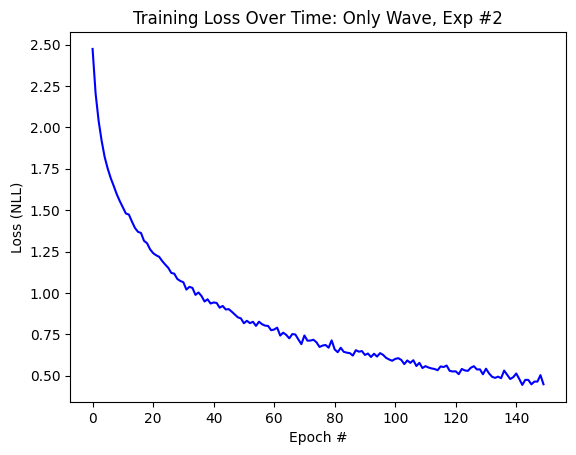

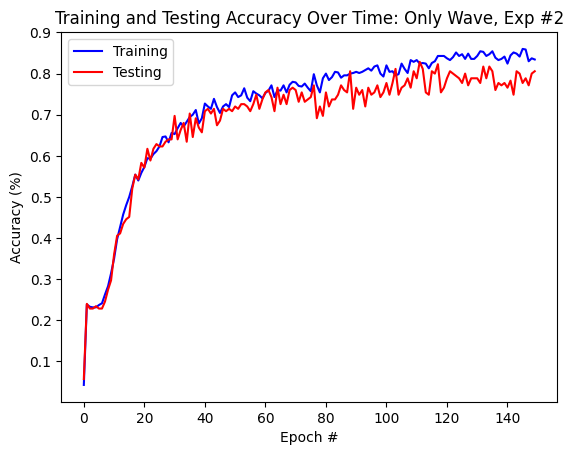

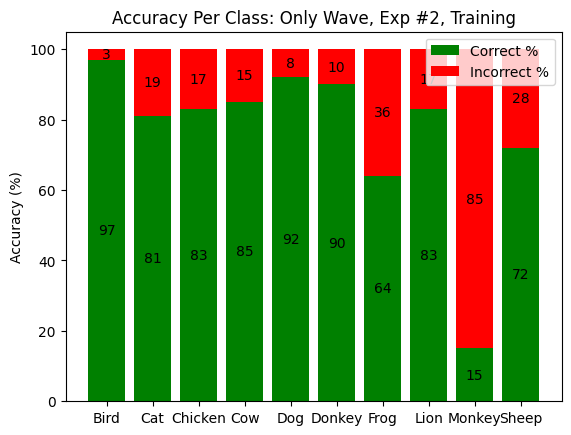

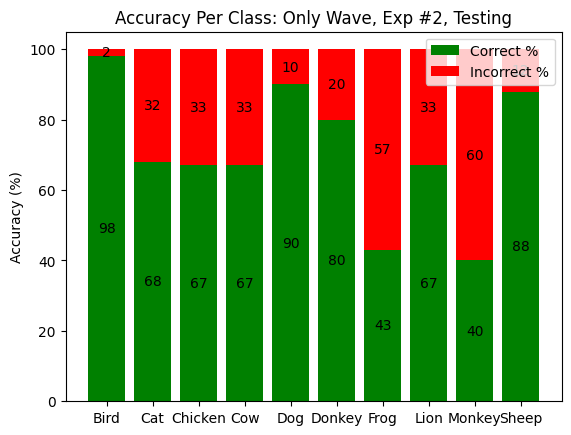

Start of epoch 0
2.57257874806722
Start of epoch 1
2.2156616846720376
Start of epoch 2
1.9857995907465618
Start of epoch 3
1.819831411043803
Start of epoch 4
1.7224267721176147
Start of epoch 5
1.625972588857015
Start of epoch 6
1.5631819168726604
Start of epoch 7
1.51780366897583
Start of epoch 8
1.4851427872975667
Start of epoch 9
1.4528746207555134
Start of epoch 10
1.4296148618062336
Start of epoch 11
1.4056354363759358
Start of epoch 12
1.395503004391988
Start of epoch 13
1.342760682106018
Start of epoch 14
1.3280267318089802
Start of epoch 15
1.3168468872706096
Start of epoch 16
1.3124971389770508
Start of epoch 17
1.2834207614262898
Start of epoch 18
1.2443822622299194
Start of epoch 19
1.253298044204712
Start of epoch 20
1.2361507018407185
Start of epoch 21
1.222061316172282
Start of epoch 22
1.2178828318913777
Start of epoch 23
1.1904948155085247
Start of epoch 24
1.1762810945510864
Start of epoch 25
1.1686927477518718
Start of epoch 26
1.1966874996821086
Start of epoch 27
1.1

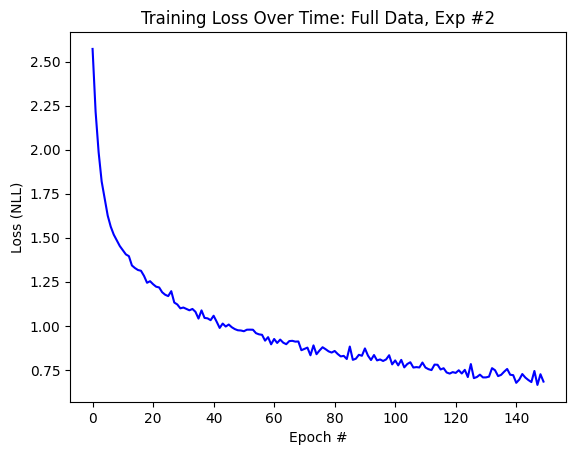

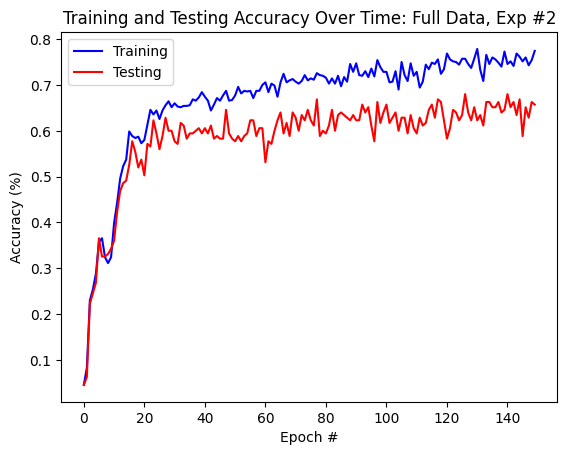

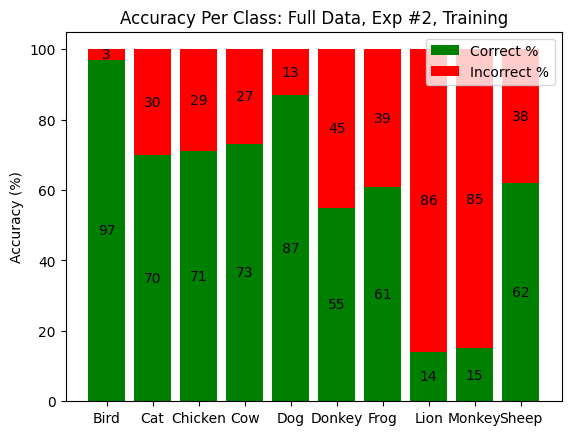

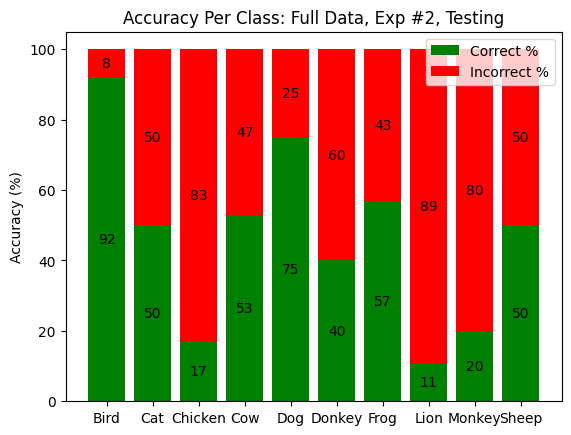

Start of epoch 0
2.5686721007029214
Start of epoch 1
2.2581381797790527
Start of epoch 2
2.0386834939320884
Start of epoch 3
1.8972280422846477
Start of epoch 4
1.7768566608428955
Start of epoch 5
1.6864343484242756
Start of epoch 6
1.5968953768412273
Start of epoch 7
1.5323176781336467
Start of epoch 8
1.5040778319040935
Start of epoch 9
1.445217768351237
Start of epoch 10
1.4195448954900105
Start of epoch 11
1.3856561183929443
Start of epoch 12
1.381170392036438
Start of epoch 13
1.3565244674682617
Start of epoch 14
1.322290261586507
Start of epoch 15
1.2883846362431843
Start of epoch 16
1.2817316850026448
Start of epoch 17
1.2784137328465779
Start of epoch 18
1.2554278373718262
Start of epoch 19
1.240997274716695
Start of epoch 20
1.2218730449676514
Start of epoch 21
1.1989925702412922
Start of epoch 22
1.1607335011164348
Start of epoch 23
1.1668837467829387
Start of epoch 24
1.1779648462931316
Start of epoch 25
1.1438494126001995
Start of epoch 26
1.1298307577768962
Start of epoch 

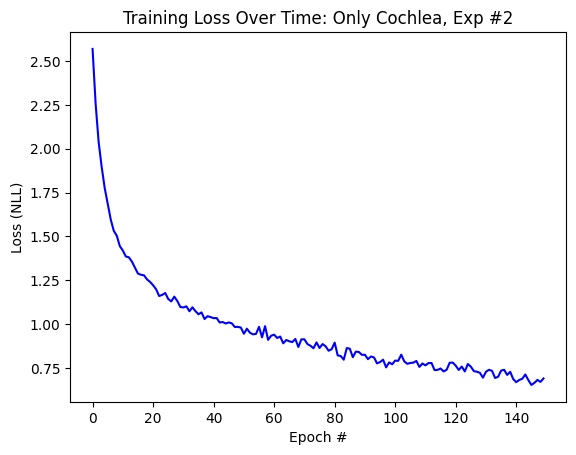

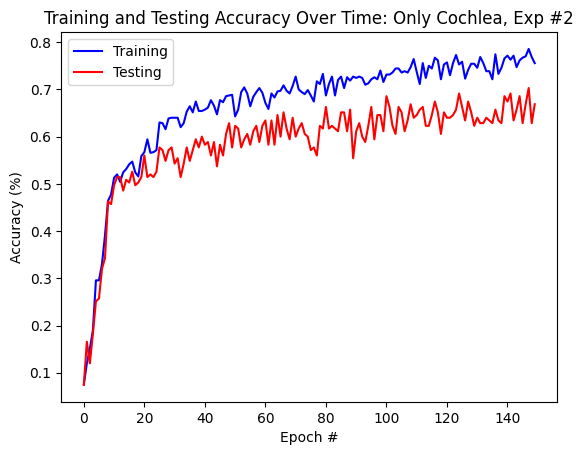

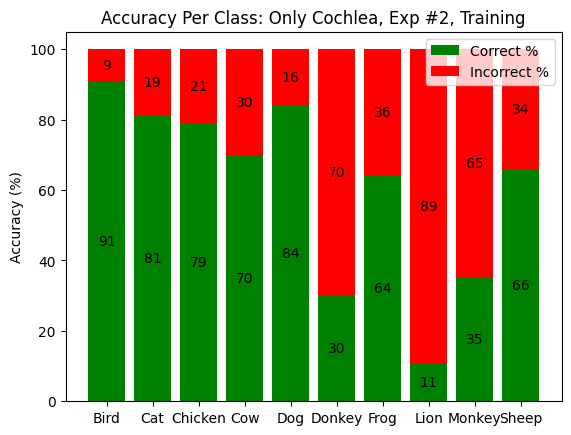

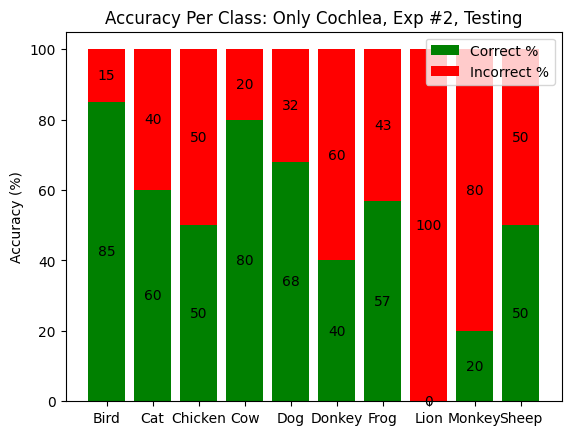

Start of epoch 0
2.2915614446004233
Start of epoch 1
2.1426260471343994
Start of epoch 2
2.029356042544047
Start of epoch 3
1.928406794865926
Start of epoch 4
1.837843894958496
Start of epoch 5
1.7611476977666218
Start of epoch 6
1.7078273296356201
Start of epoch 7
1.6569058895111084
Start of epoch 8
1.604530930519104
Start of epoch 9
1.552195429801941
Start of epoch 10
1.495083212852478
Start of epoch 11
1.49370280901591
Start of epoch 12
1.4255060752232869
Start of epoch 13
1.4146595001220703
Start of epoch 14
1.3618009090423584
Start of epoch 15
1.342727263768514
Start of epoch 16
1.323980450630188
Start of epoch 17
1.3012194236119587
Start of epoch 18
1.243575930595398
Start of epoch 19
1.2086836099624634
Start of epoch 20
1.2041093111038208
Start of epoch 21
1.1682995955149333
Start of epoch 22
1.1503143310546875
Start of epoch 23
1.1241180499394734
Start of epoch 24
1.1289673646291096
Start of epoch 25
1.0865556399027507
Start of epoch 26
1.0769636631011963
Start of epoch 27
1.08

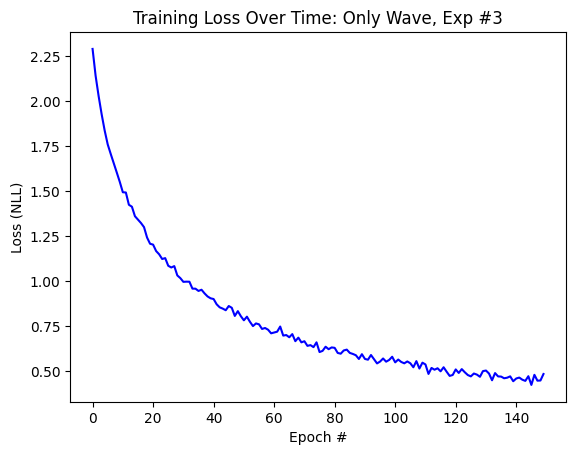

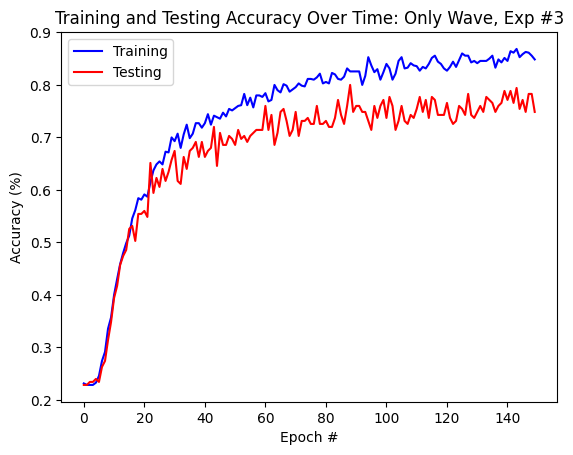

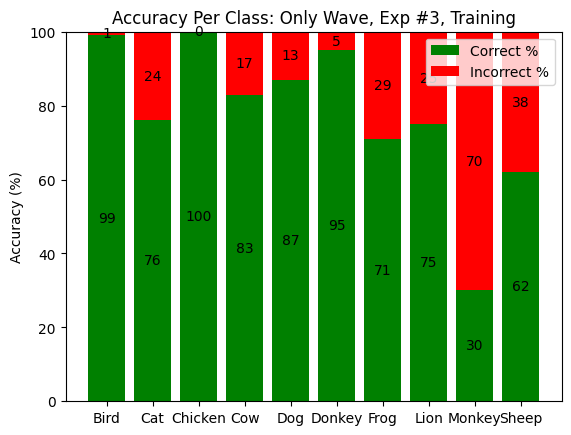

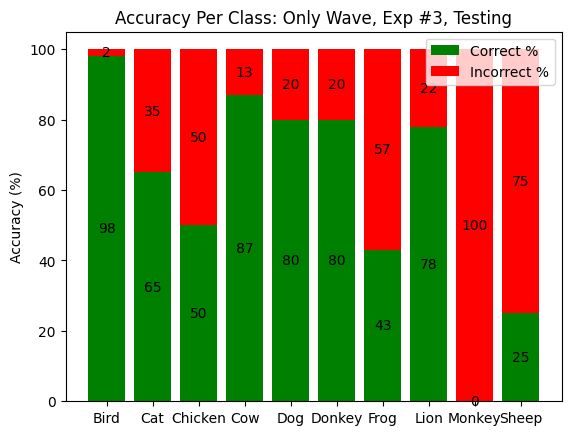

Start of epoch 0
2.4454009532928467
Start of epoch 1
2.1824533939361572
Start of epoch 2
1.979013482729594
Start of epoch 3
1.8187299966812134
Start of epoch 4
1.6933839718500774
Start of epoch 5
1.632175882657369
Start of epoch 6
1.5554694334665935
Start of epoch 7
1.5170441071192424
Start of epoch 8
1.4726505676905315
Start of epoch 9
1.4235669771830242
Start of epoch 10
1.4212598005930583
Start of epoch 11
1.3893449306488037
Start of epoch 12
1.3681774536768596
Start of epoch 13
1.3095397154490154
Start of epoch 14
1.3331398169199626
Start of epoch 15
1.307740847269694
Start of epoch 16
1.2768829663594563
Start of epoch 17
1.2887692054112752
Start of epoch 18
1.2502795855204265
Start of epoch 19
1.2435920238494873
Start of epoch 20
1.2127188046773274
Start of epoch 21
1.2120474576950073
Start of epoch 22
1.1879573663075764
Start of epoch 23
1.1864972114562988
Start of epoch 24
1.150982141494751
Start of epoch 25
1.1523910363515217
Start of epoch 26
1.140362540880839
Start of epoch 2

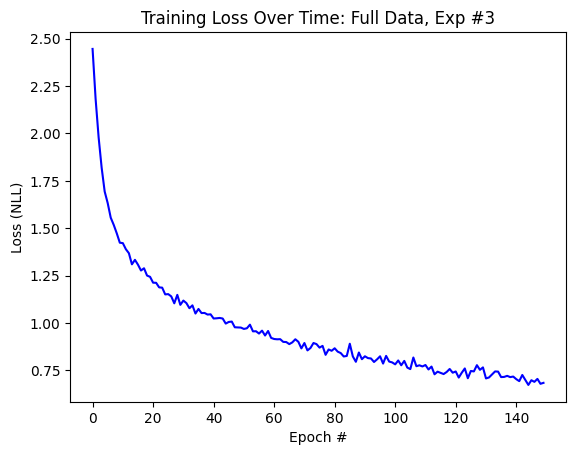

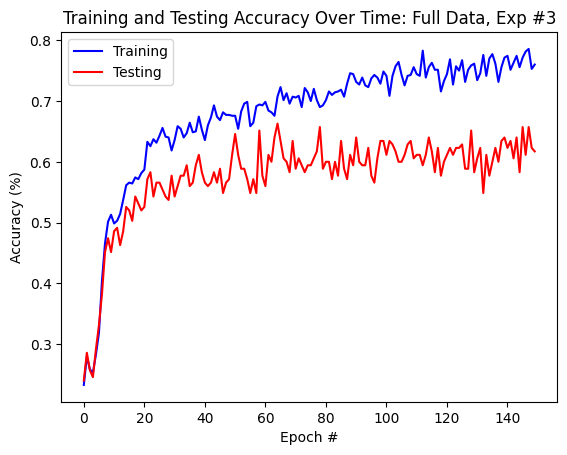

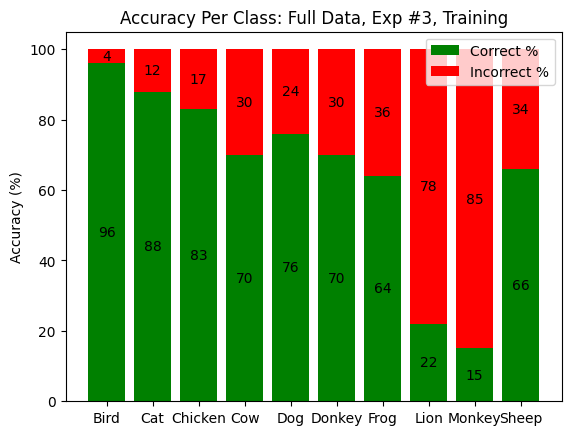

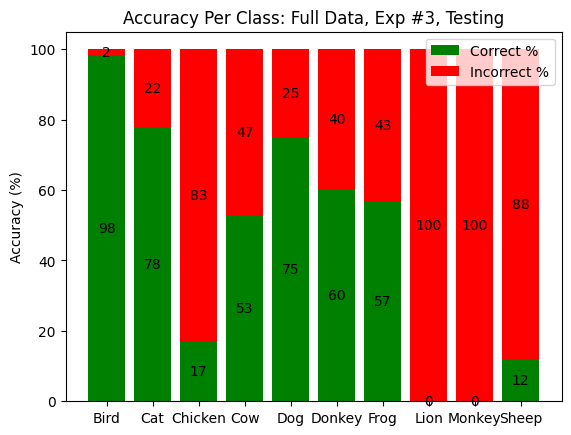

Start of epoch 0
2.3006883462270102
Start of epoch 1
1.9999350309371948
Start of epoch 2
1.8183859586715698
Start of epoch 3
1.7114317814509075
Start of epoch 4
1.6306320031483967
Start of epoch 5
1.5562566916147869
Start of epoch 6
1.515329122543335
Start of epoch 7
1.4722338914871216
Start of epoch 8
1.4418763319651287
Start of epoch 9
1.4286401669184368
Start of epoch 10
1.4001483519872029
Start of epoch 11
1.3782138427098591
Start of epoch 12
1.331769545873006
Start of epoch 13
1.31062912940979
Start of epoch 14
1.319281776746114
Start of epoch 15
1.2962427139282227
Start of epoch 16
1.2928428252538045
Start of epoch 17
1.240738312403361
Start of epoch 18
1.2590949138005574
Start of epoch 19
1.2420430580774944
Start of epoch 20
1.2104220787684123
Start of epoch 21
1.203077753384908
Start of epoch 22
1.1908145745595295
Start of epoch 23
1.1767109235127766
Start of epoch 24
1.1762351195017497
Start of epoch 25
1.1656898657480876
Start of epoch 26
1.1363153457641602
Start of epoch 27


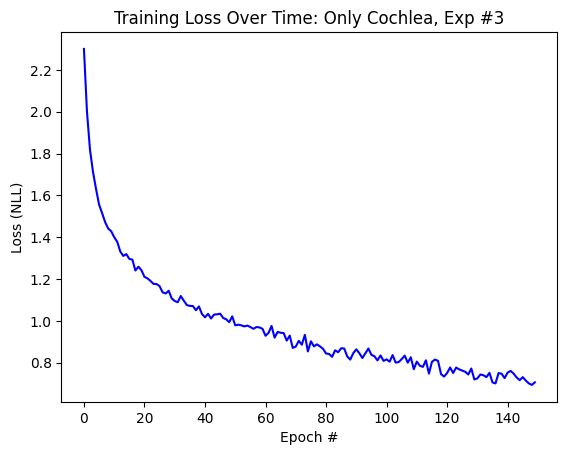

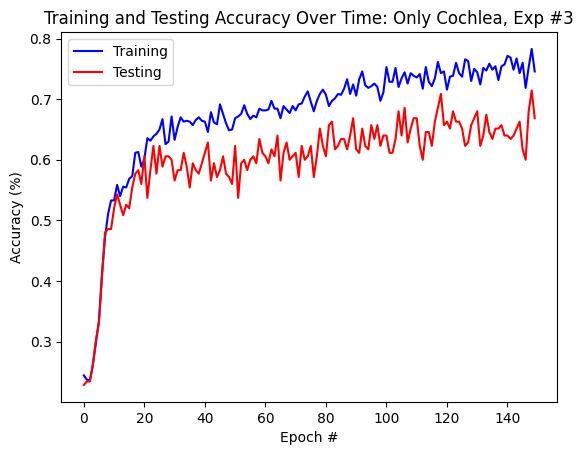

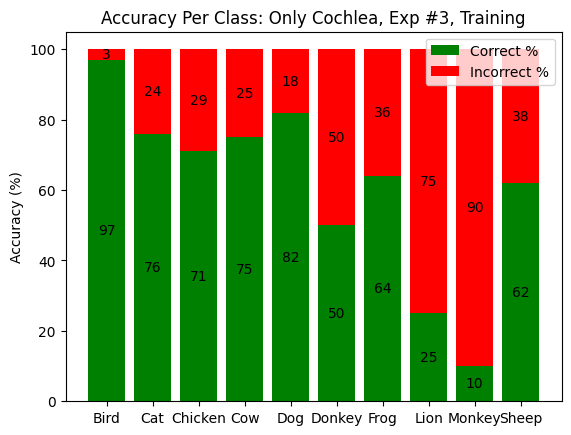

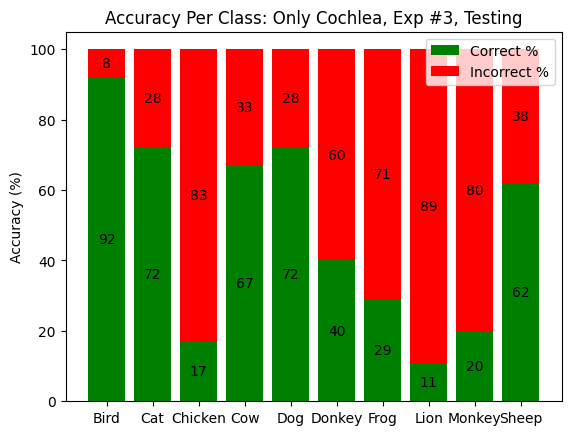

Start of epoch 0
2.3441809018452964
Start of epoch 1
2.1102685928344727
Start of epoch 2
1.9887744983037312
Start of epoch 3
1.8994100491205852
Start of epoch 4
1.822595437367757
Start of epoch 5
1.7700691223144531
Start of epoch 6
1.726182262102763
Start of epoch 7
1.658564527829488
Start of epoch 8
1.6363592942555745
Start of epoch 9
1.577126145362854
Start of epoch 10
1.5378107229868572
Start of epoch 11
1.5133702754974365
Start of epoch 12
1.4857961734135945
Start of epoch 13
1.4466493129730225
Start of epoch 14
1.3970484336217244
Start of epoch 15
1.3878586292266846
Start of epoch 16
1.3540633916854858
Start of epoch 17
1.3098268111546834
Start of epoch 18
1.3097623189290364
Start of epoch 19
1.2801677385965984
Start of epoch 20
1.258590300877889
Start of epoch 21
1.2542987664540608
Start of epoch 22
1.2078193028767903
Start of epoch 23
1.1784818172454834
Start of epoch 24
1.1695323785146077
Start of epoch 25
1.1585265795389812
Start of epoch 26
1.1348553498586018
Start of epoch 2

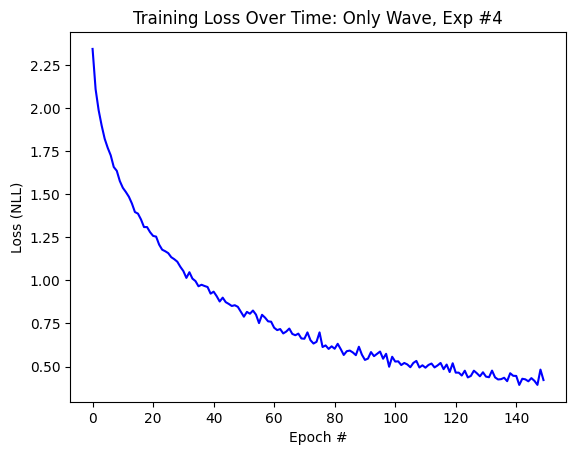

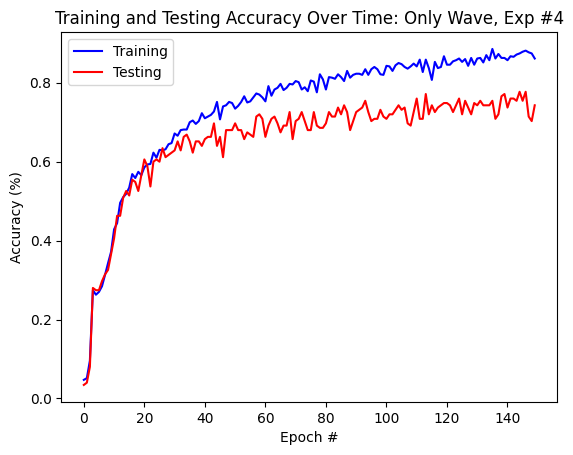

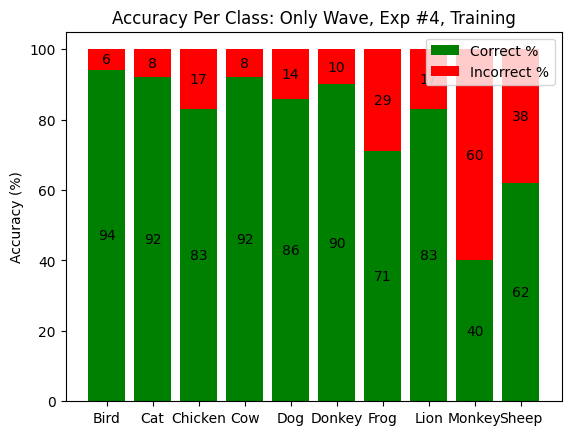

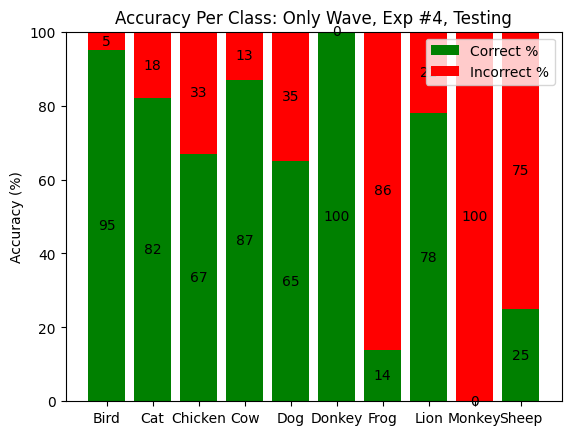

Start of epoch 0
2.0920745531717935
Start of epoch 1
1.8887947003046672
Start of epoch 2
1.7669870058695476
Start of epoch 3
1.6545392274856567
Start of epoch 4
1.5866336425145466
Start of epoch 5
1.534166693687439
Start of epoch 6
1.482786734898885
Start of epoch 7
1.4412450790405273
Start of epoch 8
1.421191692352295
Start of epoch 9
1.403506835301717
Start of epoch 10
1.374196966489156
Start of epoch 11
1.3380006154378254
Start of epoch 12
1.3130714893341064
Start of epoch 13
1.311800440152486
Start of epoch 14
1.2721381187438965
Start of epoch 15
1.256109356880188
Start of epoch 16
1.2414743502934773
Start of epoch 17
1.2369900544484456
Start of epoch 18
1.2119898398717244
Start of epoch 19
1.194812496503194
Start of epoch 20
1.186530073483785
Start of epoch 21
1.177986741065979
Start of epoch 22
1.1699483394622803
Start of epoch 23
1.1491728226343791
Start of epoch 24
1.1471065680185955
Start of epoch 25
1.1336597601572673
Start of epoch 26
1.135920802752177
Start of epoch 27
1.07

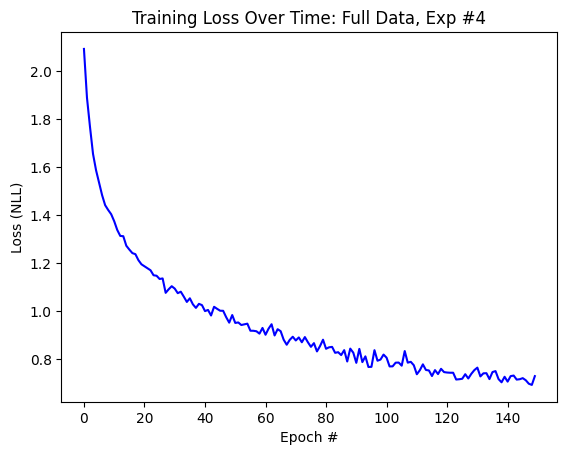

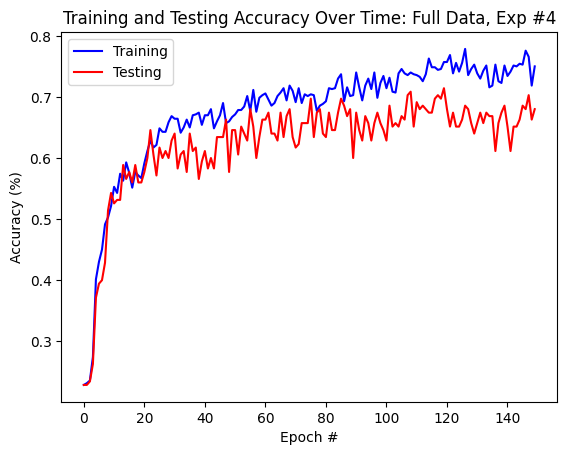

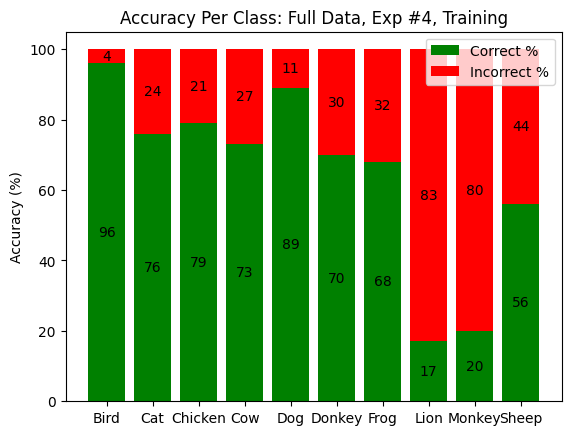

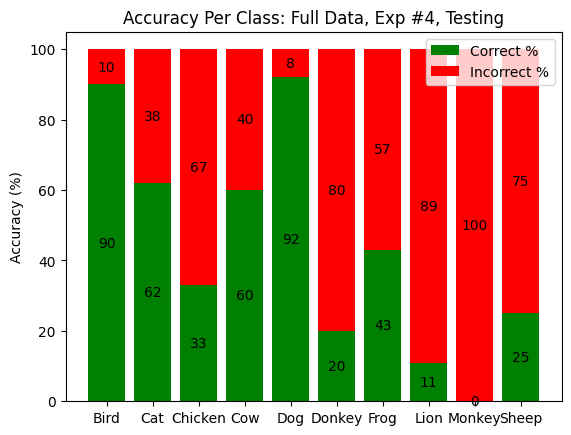

Start of epoch 0
2.908857742945353
Start of epoch 1
2.5118461449941
Start of epoch 2
2.2084604104359946
Start of epoch 3
1.9918209711710613
Start of epoch 4
1.8252689043680828
Start of epoch 5
1.6944050788879395
Start of epoch 6
1.617228110631307
Start of epoch 7
1.550197720527649
Start of epoch 8
1.4978195428848267
Start of epoch 9
1.4678010145823162
Start of epoch 10
1.4166648387908936
Start of epoch 11
1.4050660928090413
Start of epoch 12
1.3673598368962605
Start of epoch 13
1.3516743977864583
Start of epoch 14
1.3391600052515666
Start of epoch 15
1.3068767388661702
Start of epoch 16
1.284622589747111
Start of epoch 17
1.2725007931391399
Start of epoch 18
1.257313330968221
Start of epoch 19
1.2268792788187664
Start of epoch 20
1.227084755897522
Start of epoch 21
1.2241466840108235
Start of epoch 22
1.2231529553731282
Start of epoch 23
1.1751377979914348
Start of epoch 24
1.1810869773228962
Start of epoch 25
1.1499463319778442
Start of epoch 26
1.1629615624745686
Start of epoch 27
1.

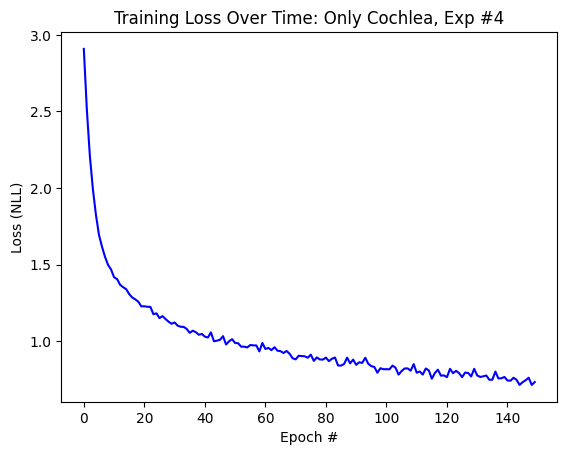

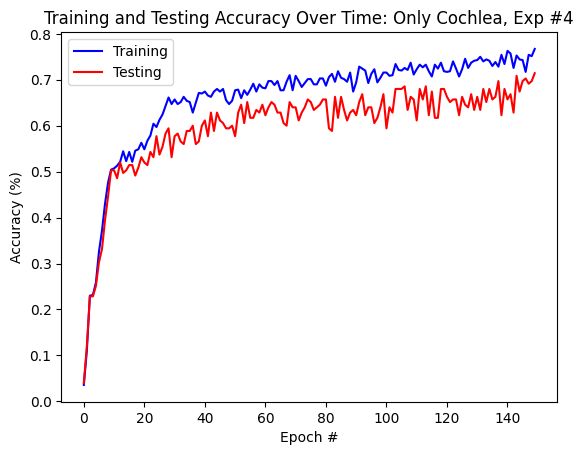

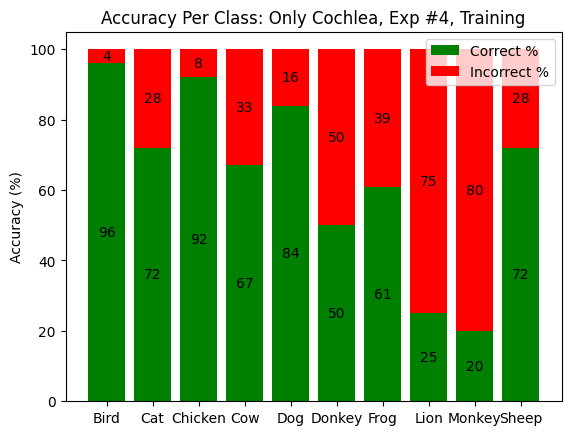

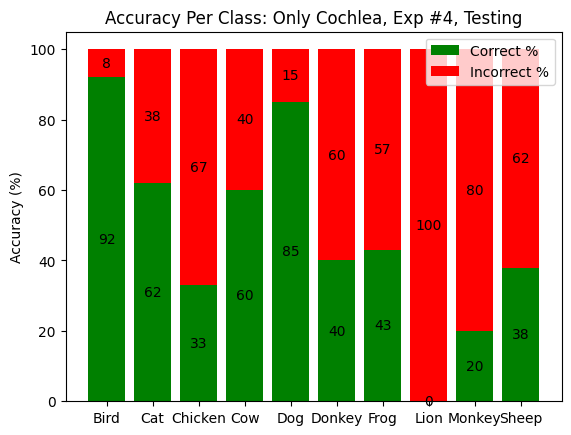

Start of epoch 0
2.2375245889027915
Start of epoch 1
2.0563596884409585
Start of epoch 2
1.9571181138356526
Start of epoch 3
1.853102485338847
Start of epoch 4
1.7867426872253418
Start of epoch 5
1.7450816631317139
Start of epoch 6
1.6812347968419392
Start of epoch 7
1.6418678363164265
Start of epoch 8
1.5795910358428955
Start of epoch 9
1.545184850692749
Start of epoch 10
1.4965535402297974
Start of epoch 11
1.4680337111155193
Start of epoch 12
1.4238636096318562
Start of epoch 13
1.4181090990702312
Start of epoch 14
1.3803904056549072
Start of epoch 15
1.3471734126408894
Start of epoch 16
1.2965623537699382
Start of epoch 17
1.2985810041427612
Start of epoch 18
1.2793456713358562
Start of epoch 19
1.2563611666361492
Start of epoch 20
1.252121090888977
Start of epoch 21
1.248608390490214
Start of epoch 22
1.1918500661849976
Start of epoch 23
1.1701186498006184
Start of epoch 24
1.1432770888010662
Start of epoch 25
1.1345707575480144
Start of epoch 26
1.1283936500549316
Start of epoch 

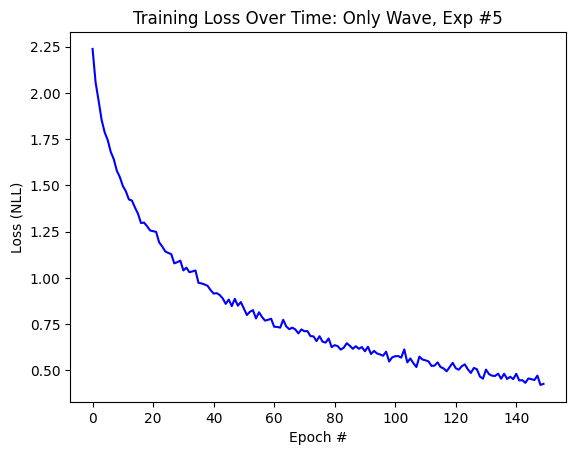

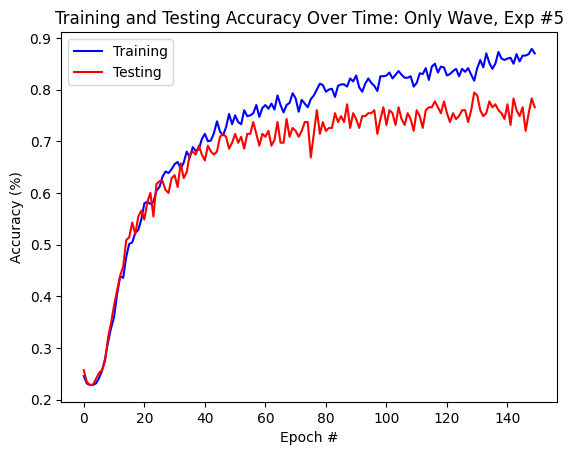

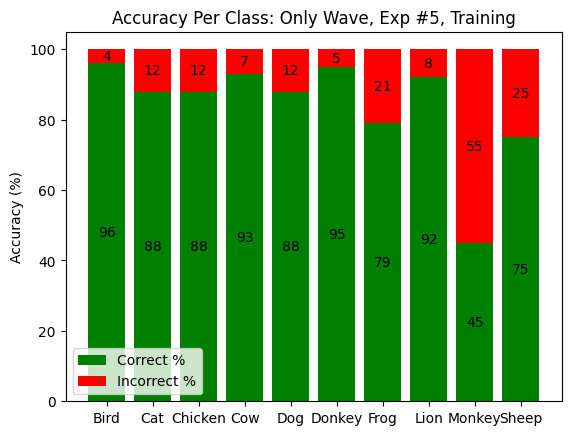

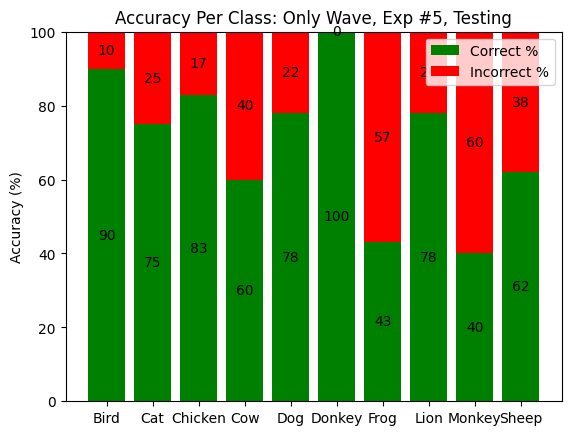

Start of epoch 0
2.269835869471232
Start of epoch 1
1.9880095720291138
Start of epoch 2
1.8130186398824055
Start of epoch 3
1.6818549235661824
Start of epoch 4
1.6125942866007488
Start of epoch 5
1.5302036205927532
Start of epoch 6
1.4788052241007488
Start of epoch 7
1.4360814889272053
Start of epoch 8
1.3915977080663045
Start of epoch 9
1.362222154935201
Start of epoch 10
1.3258384068806965
Start of epoch 11
1.300571044286092
Start of epoch 12
1.3011086384455364
Start of epoch 13
1.2726540565490723
Start of epoch 14
1.2466626564661663
Start of epoch 15
1.2203277746836345
Start of epoch 16
1.2106779019037883
Start of epoch 17
1.1923442284266155
Start of epoch 18
1.2000666459401448
Start of epoch 19
1.1503310600916545
Start of epoch 20
1.1380018790562947
Start of epoch 21
1.1288033723831177
Start of epoch 22
1.0981357097625732
Start of epoch 23
1.1051711241404216
Start of epoch 24
1.1067371765772502
Start of epoch 25
1.1069060564041138
Start of epoch 26
1.0675957202911377
Start of epoch

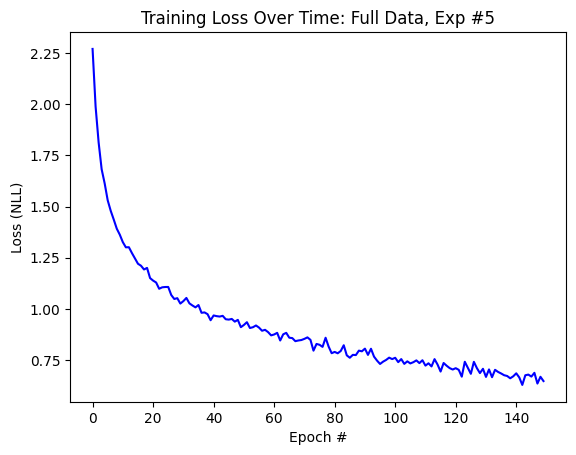

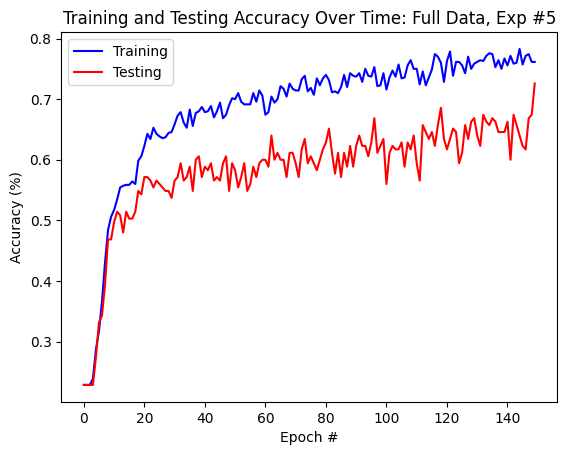

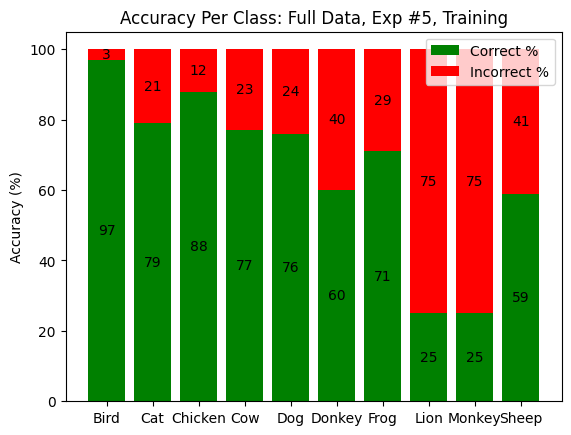

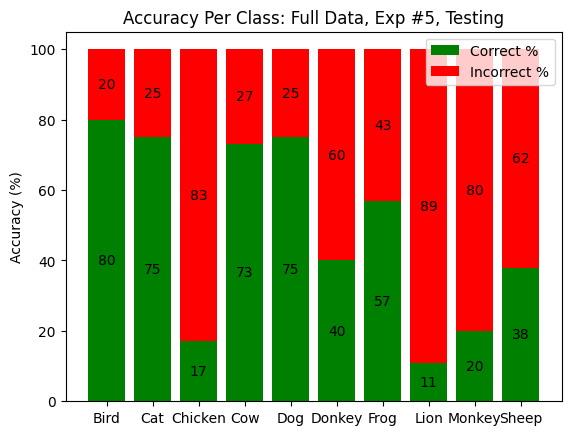

Start of epoch 0
2.218210776646932
Start of epoch 1
2.000967343648275
Start of epoch 2
1.8426954348882039
Start of epoch 3
1.7347772518793743
Start of epoch 4
1.661531964937846
Start of epoch 5
1.6101523240407307
Start of epoch 6
1.564218282699585
Start of epoch 7
1.5019925832748413
Start of epoch 8
1.4585525194803874
Start of epoch 9
1.4334981044133503
Start of epoch 10
1.4131751855214436
Start of epoch 11
1.3843226035435994
Start of epoch 12
1.3635866244633992
Start of epoch 13
1.3381515343983967
Start of epoch 14
1.3320266803105671
Start of epoch 15
1.3026026884714763
Start of epoch 16
1.2840632994969685
Start of epoch 17
1.2772065003712971
Start of epoch 18
1.2572389046351116
Start of epoch 19
1.2351181904474895
Start of epoch 20
1.252323071161906
Start of epoch 21
1.2157057126363118
Start of epoch 22
1.1705556710561116
Start of epoch 23
1.1940272251764934
Start of epoch 24
1.1640556653340657
Start of epoch 25
1.1489603519439697
Start of epoch 26
1.1513887246449788
Start of epoch 2

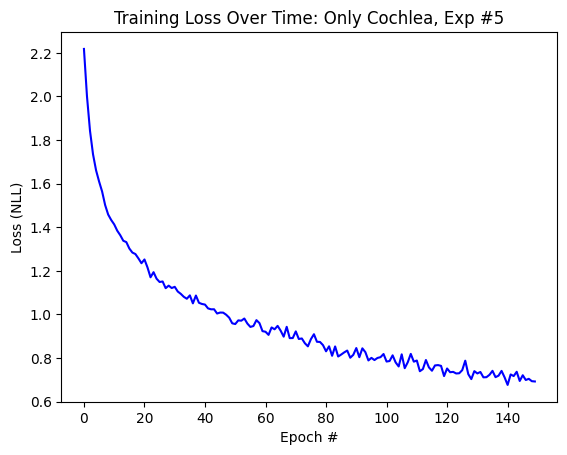

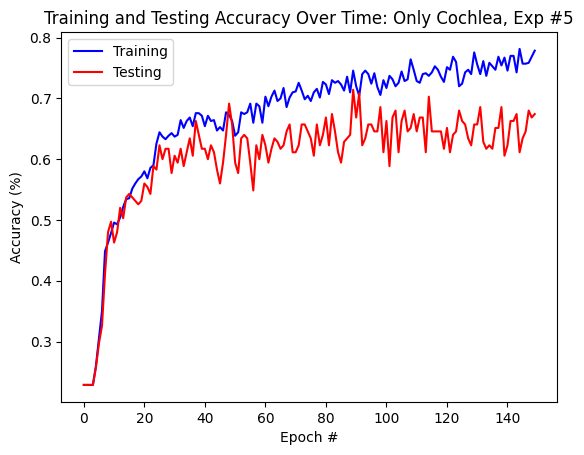

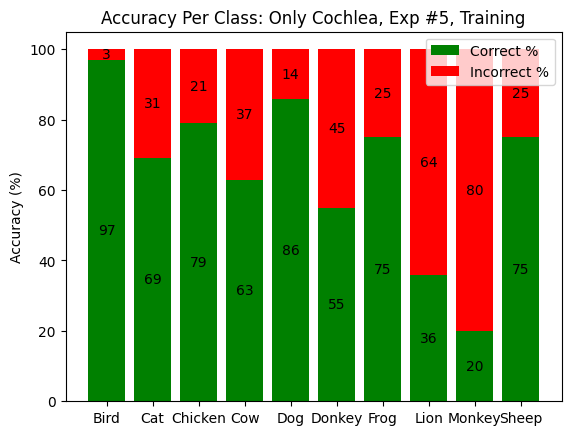

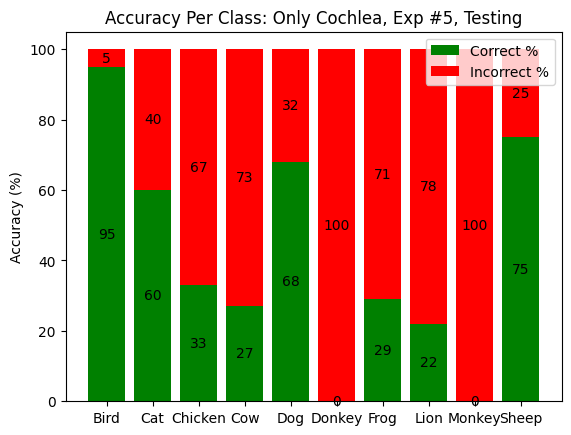

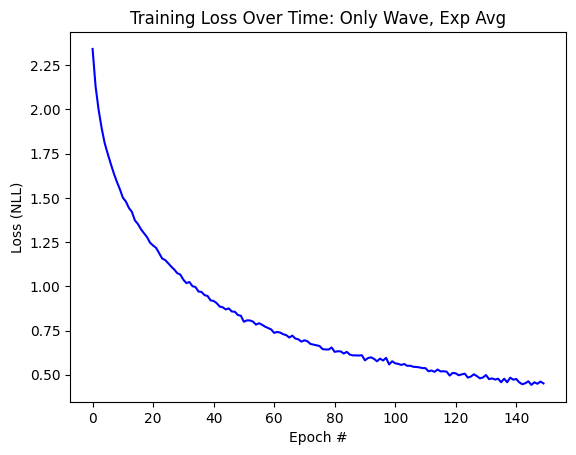

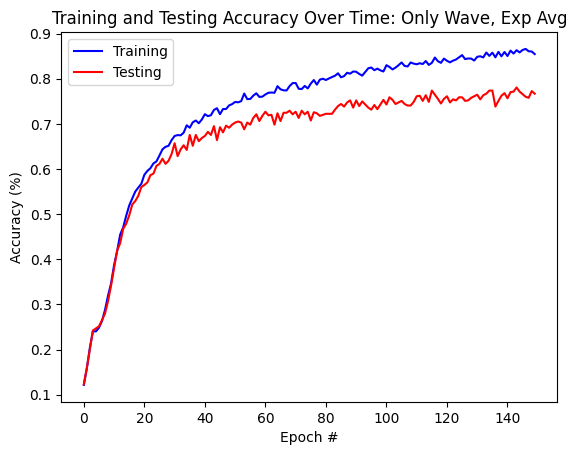

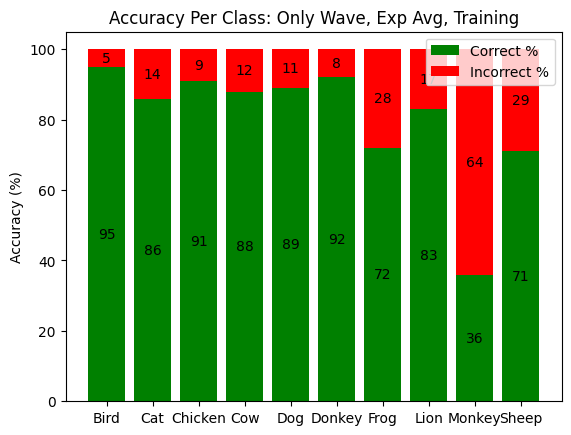

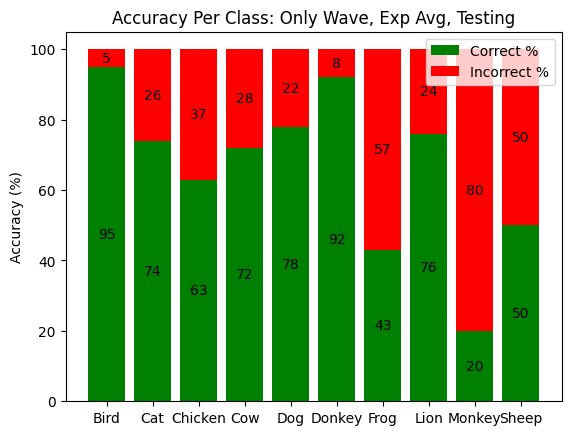

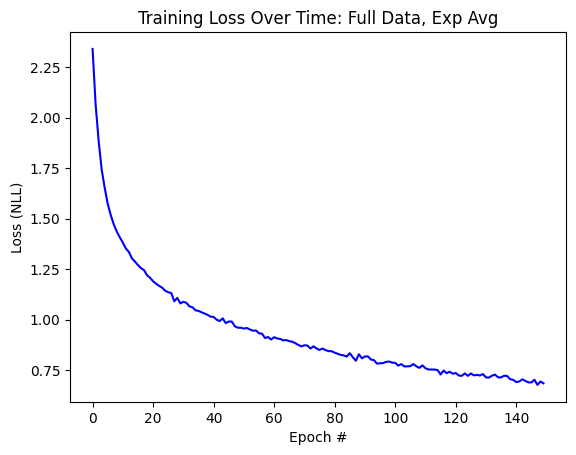

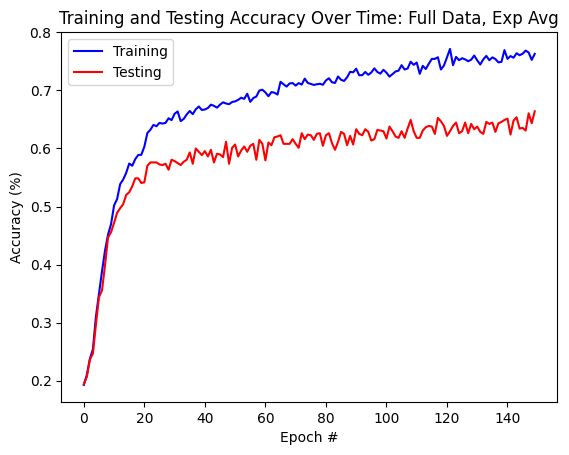

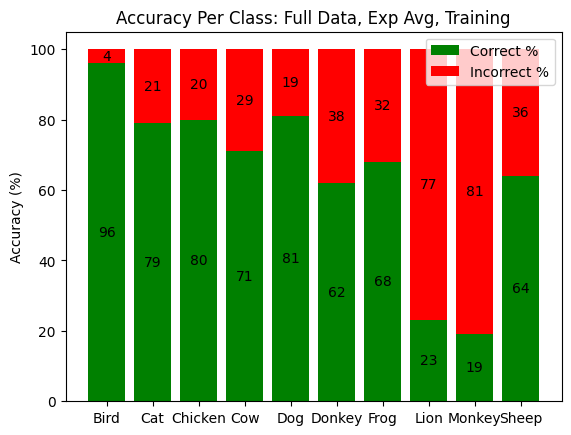

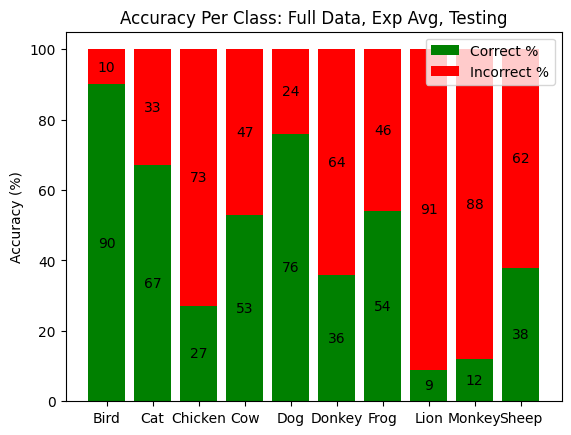

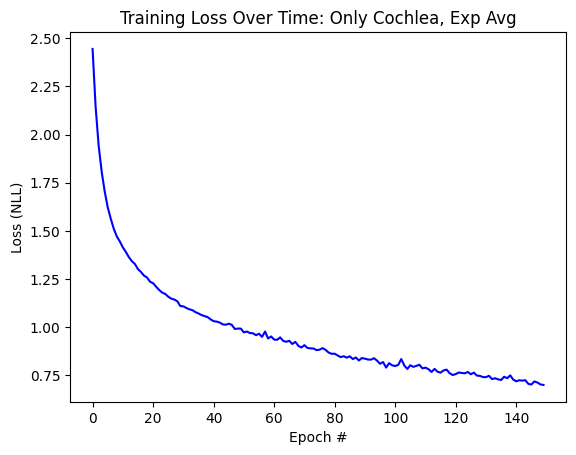

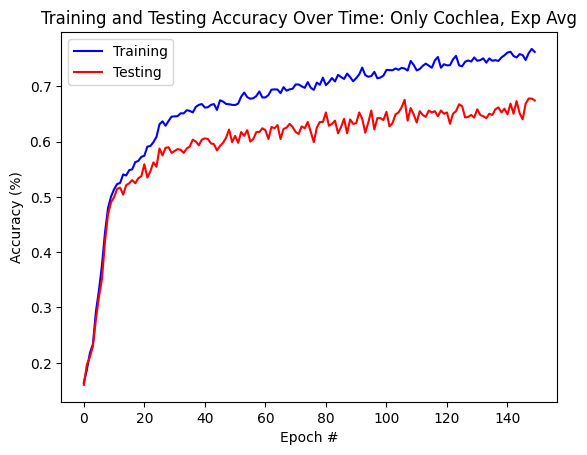

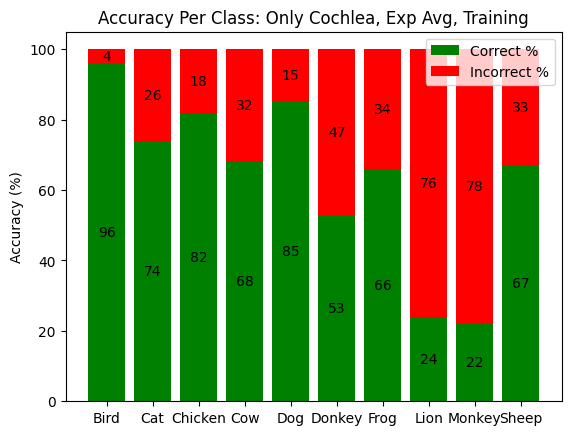

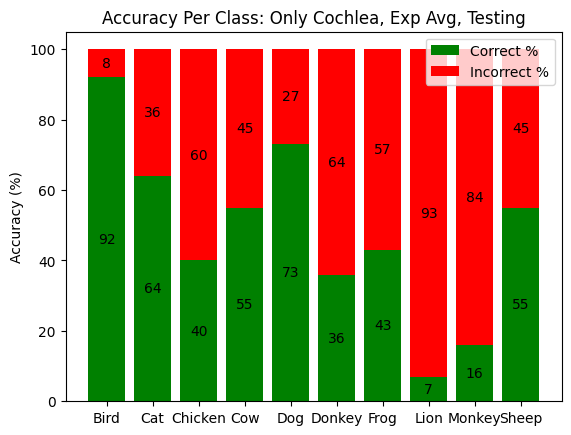

In [94]:
experiment_iterations = 5

epochs = EPOCHS

models = [(1, wave_dataset, 'wave', 'Only Wave'),
        (11, full_dataset, 'full', 'Full Data'),
        (10, freq_dataset, 'freq', 'Only Cochlea')]

total_losses = np.zeros((len(models), experiment_iterations, epochs))
total_train_accs = np.zeros((len(models), experiment_iterations, epochs))
total_test_accs = np.zeros((len(models), experiment_iterations, epochs))
total_class_train = np.zeros((len(models), experiment_iterations, len(labels)))
total_class_test = np.zeros((len(models), experiment_iterations, len(labels)))

for iter in range(experiment_iterations):
    
    for num, (inputs, dataset, type, title) in enumerate(models):
        loss_fn = nn.NLLLoss()
        model = M5(n_input=inputs, n_output=len(labels)).to(device)
        train_loader, test_loader = get_train_test_loaders(dataset)

        title_addition = ': ' + title + ', Exp #' + str(iter + 1)

        # plot_features(train_loader, type, title_addition=title_addition)

        optimizer = torch.optim.Adam(model.parameters())
        train_losses, train_accs, test_accs = train(
            model, loss_fn, optimizer, train_loader, epochs, rnn=False, get_accs=True, test_loader=test_loader
        )
        plot_loss_over_time(train_losses, title_addition=title_addition)
        total_losses[num][iter] = np.array(train_losses)

        plot_train_test_accs(train_accs, test_accs, title_addition=title_addition)
        total_train_accs[num][iter] = np.array(train_accs)
        total_test_accs[num][iter] = np.array(test_accs)

        train_class_accs = eval_per_class(model, train_loader, rnn=False)
        test_class_accs = eval_per_class(model, test_loader, rnn=False)

        total_class_train[num][iter] = np.array(train_class_accs)
        total_class_test[num][iter] = np.array(test_class_accs)

        plot_class_accuracies(train_class_accs, labels, title_addition=title_addition + ', Training')
        plot_class_accuracies(test_class_accs, labels, title_addition=title_addition + ', Testing')

avg_losses = np.mean(total_losses, 1)
avg_train_accs = np.mean(total_train_accs, 1)
avg_test_accs = np.mean(total_test_accs, 1)
avg_class_train = np.mean(total_class_train, 1)
avg_class_test = np.mean(total_class_test, 1)

std_losses = np.std(total_losses[:,:,-1], 1)
std_train_accs = np.std(total_train_accs[:,:,-1], 1)
std_test_accs = np.std(total_test_accs[:,:,-1], 1)

for num, (inputs, dataset, type, title) in enumerate(models):
    title_addition = ': ' + title + ', Exp Avg'
    plot_loss_over_time(avg_losses[num], title_addition=title_addition)
    plot_train_test_accs(avg_train_accs[num], avg_test_accs[num], title_addition=title_addition)
    plot_class_accuracies(avg_class_train[num], labels, title_addition=title_addition + ', Training')
    plot_class_accuracies(avg_class_test[num], labels, title_addition=title_addition + ', Testing')


In [95]:
print(avg_losses.shape, std_losses.shape)
for i in range(3):
    print(['wave','full','freq'][i])
    print('  loss mean', avg_losses[i][-1], 'std=', std_losses[i])
    print('  train acc mean', avg_train_accs[i][-1], 'std=', std_train_accs[i])
    print('  test acc mean', avg_test_accs[i][-1], 'std=', std_test_accs[i])

(3, 150) (3,)
wave
  loss mean 0.4511183341344197 std= 0.02494247313058034
  train acc mean 0.8545714285714286 std= 0.012235778917350773
  test acc mean 0.7668571428571428 std= 0.022101805263787102
full
  loss mean 0.684037450949351 std= 0.026209964067477328
  train acc mean 0.7628571428571428 std= 0.008231348737650234
  test acc mean 0.664 std= 0.03710327561313814
freq
  loss mean 0.6991751750310262 std= 0.01929065165166223
  train acc mean 0.7619999999999999 std= 0.01101390586708367
  test acc mean 0.6742857142857143 std= 0.022278387073849073
